In [244]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold
from datetime import datetime
from lightgbm import LGBMRegressor

In [181]:
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 12})

### Константы

In [182]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SAMPLE_SUBMIT_PATH = 'data/sample_submission.csv'
SUBMIT_PATH = 'data/submission.csv'
TARGET_NAME = 'Price'

### Вспомогательные функции

#### Импорт/Экспорт файлов

In [183]:
def from_file(path):
    return pd.read_csv(path)

def to_file(data, path):
    data.to_csv(path, index=False, encoding='utf-8', sep=',')

#### Оптимизация рамера файла

In [184]:
def get_optimized_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

#### Визуализация ответа

In [234]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    xLabel = 'Предсказанные значения'
    yLabel = 'Актуальные значения'
    
    plt.figure(figsize=(14,8))
    
    plt.subplot(121)
    plt.scatter(x=train_pred_values, y=train_true_values)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    plt.scatter(x=test_pred_values, y=test_true_values)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title('Test sample prediction')

    plt.show()

In [186]:
train = from_file(TRAIN_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [187]:
test = from_file(TEST_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [189]:
train = get_optimized_df(train)
test = get_optimized_df(test)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

### Целевая переменная

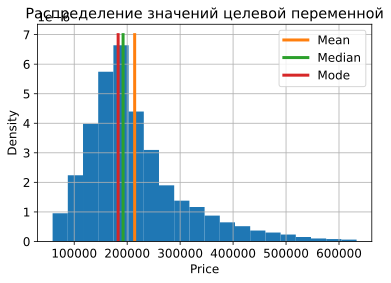

In [190]:
target_value = train[TARGET_NAME]
target_mean = target_value.mean()
target_median = target_value.median()
target_mode = target_value.mode()[0]
target_value.hist(density=True, bins=20)
y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label="Mean", linewidth=3)
plt.plot([target_median] * 10, y, label="Median", linewidth=3)
plt.plot([target_mode] * 10, y, label="Mode", linewidth=3)
plt.ylabel('Density')
plt.xlabel('Price')
plt.title('Распределение значений целевой переменной')
plt.legend()
plt.show()

Выбросов среди целевой переменной не наблюдается

### Номинативные признаки

In [191]:
train.select_dtypes(include='category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [192]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [193]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [194]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Видно, что объектов B в каждом из признаков намного больше, чем объектов A, что бы они не обозначали. Необходимо, либо закодировать эти значения, либо описать через другие количественные признаки.

### Количественные признаки

In [195]:
df_num_features = train.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop(['Price'], axis=1, inplace=True)
df_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,5202.000000
mean,1.890500,56.315777,37.199646,6.273300,12.609400,0.118858,1142.904419
std,0.839512,21.058731,86.241211,28.560917,6.775974,0.119025,1021.517273
min,0.000000,1.136859,0.370619,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,9.000000,0.017647,350.000000
50%,2.000000,52.513309,32.781261,6.000000,13.000000,0.075424,900.000000
75%,2.000000,65.900627,45.128803,9.000000,17.000000,0.195781,1548.000000
max,19.000000,641.065186,7480.592285,2014.000000,117.000000,0.521867,4849.000000


Как видно из статистики выше, есть значительные пропуски в признаках **LifeSquare** и **Healthcare_1**. Восстановление этих пропусков может вызвать сложности по разным причинам: признак с пропусками **LifeSquare** линейно связан с другими признаками (**Square**, **KitchenSquare**), а пропуски в **Healthcare_1** составляют почти 50%. Можно было бы восстановить эти значения через признак **Helthcare_2**.

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

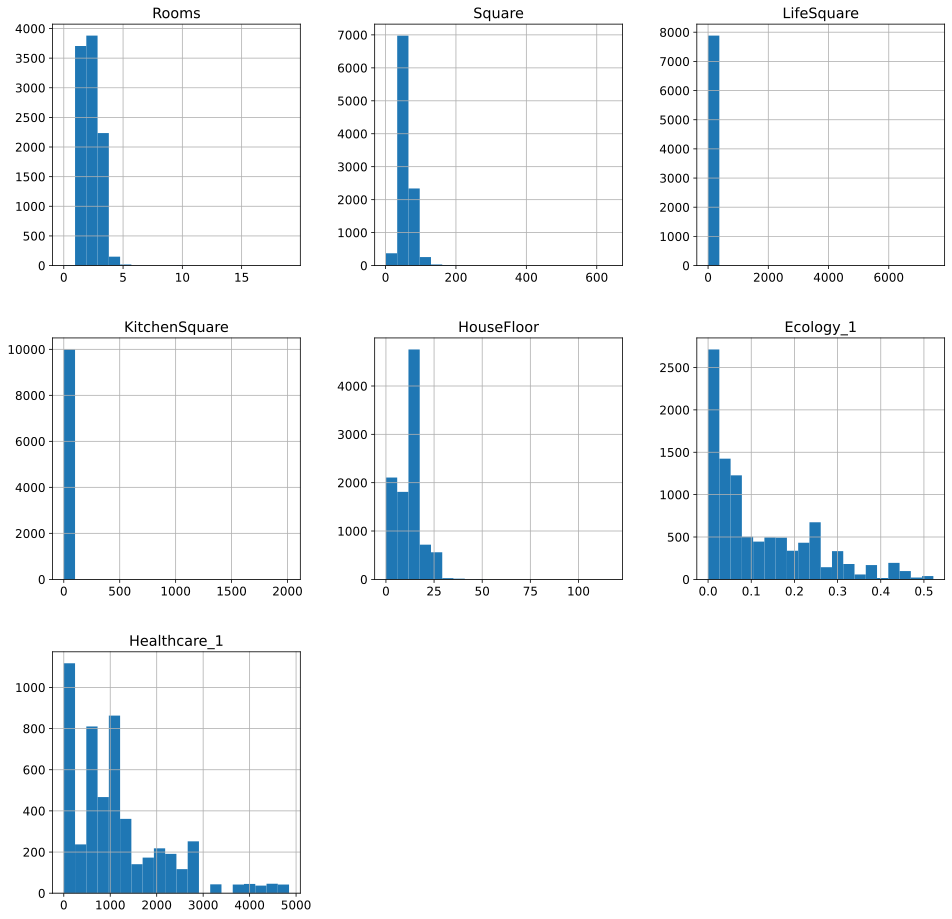

In [196]:
df_num_features.hist(figsize=(16, 16), bins=20)

Значения, очень похожие на выбросы наблюдаются в признаках: **Rooms** (общее количество комнат), **Square** (общая площадь), **LifeSquare** (общая жилая площадь), **KitchenSquare** (площадь кухни) и **HouseFloor** (количество этажей в доме).

### Обработка выбросов

#### Rooms

<AxesSubplot:>

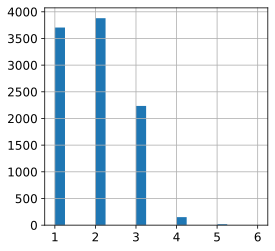

In [197]:
train[(train['Rooms'] <= 6) & (train['Rooms'] >= 1)]['Rooms'].hist(figsize=(4, 4), bins=20)

Считаем, что значения комнат более 6 - это выбросные значения, их мы будем заполнять медианным значением. В случаях, когда количество комнат == 0, скорее всего, это студии, где комната == квартира. В таких случаях, мы будем заполнять количество комнат равное 1.

In [198]:
train['Rooms_outlier'] = 0
train.loc[(train['Rooms'] > 6) | (train['Rooms'] < 1), 'Rooms_outlier'] = 1
train.loc[train['Rooms'] == 0, 'Rooms'] = 1
train.loc[train['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()

#### Square

<AxesSubplot:>

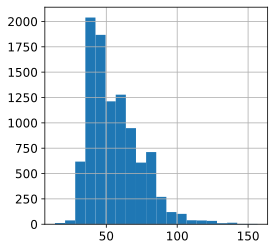

In [199]:
train[(train['Square'] <= 160) & (train['Square'] >= 10)]['Square'].hist(figsize=(4, 4), bins=20)

In [200]:
train['Sqaure_outlier'] = 0
train.loc[(train['Square'] < 10) | (train['Square'] > 160), 'Sqaure_outlier'] = 1
train.loc[train['Sqaure_outlier'] == 1, 'Square'] = train['Square'].median()

In [201]:
train.loc[(train['LifeSquare'] + train['KitchenSquare'] > train['Square']), ['Square', 'LifeSquare', 'KitchenSquare', 'Price']]

,Square,LifeSquare,KitchenSquare,Price
33,73.314972,74.131264,1.0,254005.375000
34,58.783661,55.441257,11.0,138396.984375
42,53.179790,50.643795,5.0,308108.218750
48,40.064915,38.733288,8.0,160810.546875
64,87.200623,87.730225,0.0,300180.375000
...,...,...,...,...
9960,96.056786,98.152802,1.0,524365.562500
9962,42.029175,44.682167,10.0,87556.382812
9979,40.043236,41.984322,1.0,134888.078125
9987,62.690056,64.602936,10.0,203908.187500


Среди показателей Square, LifeSquare, KitchenSquare много неадекватных, невалидных значений. KitchenSquare и LifeSquare составляют Square. Надо взять какой-либо макимально адекватный показатель среди указанных, и на его основе восстановить зависимость. В KitchenSquare много пропусков, его сразу откидываем. Между LifeSquare и Square выбираем Sqaure как ближайшего к истине. Возьмём наблюдения с адекватным соотношением площадей квартир (выборку, где KitchenSquare + LifeSquare < Sqaure) и посчитаем на ней долю жилой площади и площади кухни в общей площади.

После берём выборку с неадкветным соотношением площадей (KitchenSquare + LifeSquare >= Sqaure), берём за основу Square и восстановим актуальные KitchenSquare и LifeSquare, используя посчитанные доли жилой площади и площади кухни так что: KitchenSquare = kitchen_ratio * Square; LifeSquare = life_ratio * Sqaure.

In [202]:
valid_squares = train[train['LifeSquare'] + train['KitchenSquare'] < train['Square']]

In [203]:
kitchen_ratio = (valid_squares['KitchenSquare'] / valid_squares['Square'] * 100).median()
kitchen_ratio

13.898943

In [204]:
life_ratio = (valid_squares['LifeSquare'] / valid_squares['Square'] * 100).median()
life_ratio

60.515766

#### Floor, HouseFloor

In [205]:
train['HouseFloor_outlier'] = 0
train.loc[train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [206]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = 1
        
floor_outliers = train.loc[train['Floor'] > train['HouseFloor']].index
train.loc[floor_outliers, 'Floor'] = train['HouseFloor']

#### HouseYear

In [207]:
train['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [208]:
train[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Sqaure_outlier,HouseFloor_outlier
8828,11607,147,2.0,44.791836,28.360394,5.0,4.0,9.0,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.609375,0,0,0
9163,10814,109,1.0,37.265072,20.239714,9.0,9.0,12.0,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.531250,0,0,0


Есть выбросные значения, заменим их на текущий год

In [209]:
current_year = datetime.now().year
train['HouseYear_outlier'] = 0
train.loc[train['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
train.loc[train['HouseYear'] > current_year, 'HouseYear'] = current_year

### Обработка пропусков

In [210]:
train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Sqaure_outlier           0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

- **LifeSquare**. Про обработку пропусков данного признака написано выше, в блоке **Square**.
- **Healthcare_1**. Будем восстанавливать признак с помощью признака **Helthcare_2**.

#### Healthcare_1

In [211]:
healthcare_1_median_value_by_group = {}

In [212]:
helthcare_2_groups = pd.unique(train['Helthcare_2']).tolist()
helthcare_2_groups

[0, 1, 3, 2, 5, 4, 6]

In [213]:
for group in helthcare_2_groups:
            healthcare_1_median_value = train.loc[(train['Helthcare_2'] == group), 'Healthcare_1'].median()
            healthcare_1_median_value_by_group[group] = healthcare_1_median_value
            
healthcare_1_median_value_by_group

{0: 540.0, 1: 620.0, 3: 1145.0, 2: 750.0, 5: 1575.0, 4: 1894.0, 6: 645.0}

Медианные значения **Healthcare_1**, сгруппированные по **Helthcare_2**

In [214]:
train['Healthcare_1_outlier'] = 0
train.loc[train['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
train.loc[train['Healthcare_1_outlier'] == 1, 'Healthcare_1'] = train['Helthcare_2'].map(healthcare_1_median_value_by_group)
train.loc[train['Healthcare_1_outlier'] == 1, ['Healthcare_1', 'Helthcare_2']].head()

,Healthcare_1,Helthcare_2
0,540.0,0
3,540.0,0
4,540.0,0
8,540.0,0
11,1145.0,3


### Преобразование данных

In [215]:
class DataPreprocessing:
    def __init__(self):
        """Параметры класса"""
        
        self.medians = None
        self.current_year = datetime.now().year
        self.kitchen_square_ratio = None
        self.life_sqaure_ratio = None
        self.healthcare_1_median_value_by_group = {}
        
    def fit(self, df):
        """Сохранение статистик"""
        
        self.medians = df.median()
        
        valid_squares = df[df['LifeSquare'] + df['KitchenSquare'] >= df['Square']]
        self.kitchen_square_ratio = (valid_squares['KitchenSquare'] / valid_squares['Square'] * 100).median()
        self.life_sqaure_ratio = (valid_squares['LifeSquare'] / valid_squares['Square'] * 100).median()
        
        helthcare_2_groups = pd.unique(df['Helthcare_2']).tolist()
        for group in helthcare_2_groups:
            healthcare_1_median_value = df.loc[(df['Helthcare_2'] == group), 'Healthcare_1'].median()
            self.healthcare_1_median_value_by_group[group] = healthcare_1_median_value
        
    
    def transform(self, df):
        """Трансформация данных"""
        
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 6), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # HouseYear
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > self.current_year, 'HouseYear_outlier'] = 1
        df.loc[df['HouseYear'] > self.current_year, 'HouseYear'] = self.current_year
        
        # Square, LifeSquare, KitchenSquare
        df['Sqaure_outlier'] = 0
        df.loc[(df['Square'] < 10) | (df['Square'] > 160), 'Sqaure_outlier'] = 1
        df.loc[df['Sqaure_outlier'] == 1, 'Square'] = self.medians['Square']
        
        df.loc[(df['LifeSquare'] + df['KitchenSquare'] >= df['Square']) | (df['Sqaure_outlier'] == 1), 'LifeSquare'] = self.life_sqaure_ratio * df['Square']
        df.loc[(df['LifeSquare'] + df['KitchenSquare'] >= df['Square']) | (df['Sqaure_outlier'] == 1), 'KitchenSquare'] = self.kitchen_square_ratio * df['Square']
        
        # Floor, HouseFloor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = 1
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df['HouseFloor']
        
        # Healthcare_1
        df['Healthcare_1_outlier'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        df.loc[df['Healthcare_1_outlier'] == 1, 'Healthcare_1'] = df['Helthcare_2'].map(self.healthcare_1_median_value_by_group)
        
        df.fillna(self.medians, inplace=True)
        return df

### Генерация новых признаков

#### MedianPricePerMeterByDictrict

Медианная цена за квадратный метр по районам (**DistrictId**)

In [216]:
train['PricePerMeter'] = train['Price'] / train['Square']
train['PricePerMeter']

0       2651.708252
1       4462.045898
2       3600.596680
3       4160.019531
4       5351.088867
           ...     
9995    2431.568115
9996    3105.618652
9997    5597.463379
9998    5315.213379
9999    4961.141113
Name: PricePerMeter, Length: 10000, dtype: float32

In [217]:
median_price_per_meter_by_district = train\
                .groupby(['DistrictId'], as_index=False)\
                .agg({'PricePerMeter': 'median'})\
                .rename(columns={'PricePerMeter':'MedianPricePerMeterByDictrict'})
median_price_per_meter_by_district

,DistrictId,MedianPricePerMeterByDictrict
0,0,3935.906738
1,1,3251.647461
2,2,4550.708984
3,3,3892.203857
4,4,5716.888672
...,...,...
200,202,7447.527832
201,205,5101.016602
202,207,5550.678223
203,208,8005.604492


In [218]:
train = train.merge(median_price_per_meter_by_district, on=['DistrictId'], how='left')
train[['DistrictId', 'Square', 'Price', 'MedianPricePerMeterByDictrict']].head()

,DistrictId,Square,Price,MedianPricePerMeterByDictrict
0,27,115.027313,305018.875000,2760.361328
1,22,39.832523,177734.546875,3553.678467
2,1,78.342216,282078.718750,3251.647461
3,1,40.409908,168106.000000,3251.647461
4,94,64.285065,343995.093750,4219.992676


#### MedianPriceBySocial

Свяжем социальные показатели местности с конечной ценой

In [219]:
median_price_by_social = train\
                .groupby(['Social_2', 'Social_1', 'Social_3'])\
                .agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceBySocial'})
median_price_by_social

,,,MedianPriceBySocial
Social_2,Social_1,Social_3,
168,0,0,94177.890625
186,0,0,196538.375000
264,1,0,183882.812500
290,1,0,88676.085938
388,1,0,90431.000000
...,...,...,...
11395,49,3,191608.859375
12238,50,8,228872.125000
13670,53,4,272731.187500


In [220]:
train = train.merge(median_price_by_social, on=['Social_1', 'Social_2', 'Social_3'], how='left')
train[['Social_1', 'Social_2', 'Social_3', 'Price', 'MedianPriceBySocial']].head()

,Social_1,Social_2,Social_3,Price,MedianPriceBySocial
0,11,3097,0,305018.875000,148315.421875
1,30,6207,1,177734.546875,186809.593750
2,33,5261,0,282078.718750,205993.375000
3,1,264,0,168106.000000,183882.812500
4,33,8667,2,343995.093750,203153.531250


То же самое мы проделаем с показателями местности, связанными с охраной здоровья (**Healthcare_1**, **Helthcare_2**) и с показателями, связанными с наличием магазинов, торговых центров (**Shops_1**, **Shops_2**)

In [221]:
class FeatureGenetator:
    """Генерация новых фич"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.median_price_per_meter_by_district = None
        self.median_price_by_social = None
        self.median_price_by_helthcare = None
        self.median_price_by_shops = None
        self.med_price_by_district = None
        
    def fit(self, df, target=None):
        """Сохранение статистик"""
        
        df_copy = df.copy()
        
        if target is not None:
            df_copy['Price'] = target
            df_copy['PricePerMeter'] = df_copy['Price'] / df_copy['Square']
            self.median_price_per_meter_by_district = df_copy\
                .groupby(['DistrictId'], as_index=False)\
                .agg({'PricePerMeter': 'median'})\
                .rename(columns={'PricePerMeter':'MedianPricePerMeterByDictrict'})
            
            self.median_price_per_meter_by_district_med = self.median_price_per_meter_by_district['MedianPricePerMeterByDictrict'].median()
            
        if target is not None:
            self.median_price_by_social = df_copy\
                .groupby(['Social_2', 'Social_1', 'Social_3'])\
                .agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceBySocial'})
                
            self.median_price_by_social_med = self.median_price_by_social['MedianPriceBySocial'].median()
            
        if target is not None:
            self.median_price_by_helthcare = df_copy\
                .groupby(['Healthcare_1', 'Helthcare_2'])\
                .agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceByHealthcare'})
                
            self.median_price_by_helthcare_med = self.median_price_by_helthcare['MedianPriceByHealthcare'].median()
            
        if target is not None:
            self.median_price_by_shops = df_copy\
                .groupby(['Shops_1', 'Shops_2'])\
                .agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceByShops'})
                
            self.median_price_by_shops_med = self.median_price_by_shops['MedianPriceByShops'].median()
            
        if target is not None:
            self.med_price_by_district = df_copy\
                .groupby(['DistrictId', 'Rooms'], as_index=False)\
                .agg({'Price':'median'})\
                .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        ## MeanPricePerSquareMeterByDictrict
        if self.median_price_per_meter_by_district is not None:
            df = df.merge(self.median_price_per_meter_by_district, on=['DistrictId'], how='left')
            df['MedianPricePerMeterByDictrict'].fillna(self.median_price_per_meter_by_district_med, inplace=True)
            
        ## MedianPriceBySocial
        if self.median_price_by_social is not None:
            df = df.merge(self.median_price_by_social, on=['Social_1', 'Social_2', 'Social_3'], how='left')
            df['MedianPriceBySocial'].fillna(self.median_price_by_social_med, inplace=True)
            
        ## MedianPriceByHealthcare
        if self.median_price_by_helthcare is not None:
            df = df.merge(self.median_price_by_helthcare, on=['Healthcare_1', 'Helthcare_2'], how='left')
            df['MedianPriceByHealthcare'].fillna(self.median_price_by_helthcare_med, inplace=True)
            
        ## MedianPriceByShops
        if self.median_price_by_shops is not None:
            df = df.merge(self.median_price_by_shops, on=['Shops_1', 'Shops_2'], how='left')
            df['MedianPriceByShops'].fillna(self.median_price_by_shops_med, inplace=True)
        
        ## MedPriceByDistrict
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        ## Binary Dummies
        df = pd.get_dummies(df)
        
        return df

### Отбор признаков

In [222]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Sqaure_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'Healthcare_1_outlier',
 'PricePerMeter',
 'MedianPricePerMeterByDictrict',
 'MedianPriceBySocial']

In [223]:
FEATURE_NAMES = [
    'Rooms', 
    'Square', 
    'LifeSquare', 
    'KitchenSquare', 
    'Floor', 
    'HouseFloor', 
    'HouseYear',
    'Ecology_1'
]

NEW_FEATURE_NAMES = [
    'Rooms_outlier', 
    'HouseFloor_outlier', 
    'HouseYear_outlier', 
    'MedianPricePerMeterByDictrict',
    'MedPriceByDistrict',
    'MedianPriceBySocial',
    'MedianPriceByHealthcare',
    'Healthcare_1_outlier',
    'MedianPriceByShops',
]

### Разбиение данных

In [224]:
train_df = from_file(TRAIN_PATH)
test_df = from_file(TEST_PATH)

X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

In [225]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=100)

In [226]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 24), (2000, 24), (5000, 24))

In [227]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 32), (2000, 32), (5000, 32))

In [228]:
X_train = X_train[FEATURE_NAMES + NEW_FEATURE_NAMES]
X_valid = X_valid[FEATURE_NAMES + NEW_FEATURE_NAMES]
test_df = test_df[FEATURE_NAMES + NEW_FEATURE_NAMES]

In [229]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

In [230]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

Train R2:	0.947
Test R2:	0.736


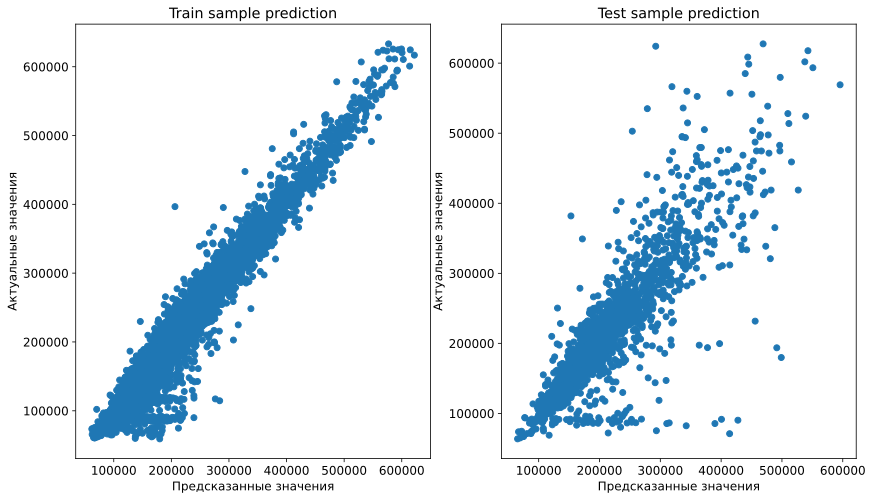

In [236]:
model = LGBMRegressor(
    max_bin=110,
    n_estimators=4000,
    learning_rate=0.01
)
model.fit(X_train, y_train)

y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [237]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=100))
cv_score

array([0.77036359, 0.76264142, 0.79610824, 0.76244104, 0.73427726])

In [238]:
cv_score.mean()

0.7651663112214375

In [239]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,17125
6,HouseYear,14216
12,MedPriceByDistrict,12046
2,LifeSquare,11284
11,MedianPricePerMeterByDictrict,10505
4,Floor,9539
7,Ecology_1,8693
5,HouseFloor,8337
13,MedianPriceBySocial,7931
3,KitchenSquare,7422


### Прогнозирование на тестовом датасете

Возьмём обученную модельку, макет для результирующего файла (SAMPLE_SUBMIT_PATH), сделаем предсказание с тестовой выборкой, подставим Price в макет и сохраним результат в SUBMIT_PATH.

In [240]:
submit = from_file(SAMPLE_SUBMIT_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [241]:
predictions = model.predict(test_df)
predictions

array([168950.01252325, 122659.38331756, 143892.95619699, ...,
       148529.44136453, 191791.68718882, 255232.27250496])

In [242]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168950.012523
1,5925,122659.383318
2,960,143892.956197
3,3848,130784.170597
4,746,179409.029896


In [243]:
to_file(submit, SUBMIT_PATH)